In [1]:
from scipy import sparse
from bluepysnap import Circuit
from graph_analysis.randomize import WeightPermutedRandomModel
from graph_analysis.rich_cub import RichClubAnalysis
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
file_format = 'png'
dpi = 300

In [3]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
target_synaptome = synaptome[target_indices,:][:,target_indices]
target_connectome = connectome[target_indices,:][:,target_indices]

In [ ]:
# model_dp = WeightPermutedRandomModel(target_synaptome)

# random_adjs = []

# for i in tqdm(range(100)):
#     dp_adj = model_dp.generate(seed=i)
#     random_adjs.append(dp_adj)

In [ ]:
# calculate the rich club coefficients for the original graph
rca_syn = RichClubAnalysis(target_synaptome)
client = Client()    # Start Dask client
k_dict_parallel_model = rca_syn.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
client.shutdown()    # Shutdown the Dask client

INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:45294. Reason: nanny-close
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:34134. Reason: nanny-close
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:40670. Reason: nanny-close
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:40418. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:39619 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:42432. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:39619 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:33940. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:39619 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:35279. Reason: nanny-close
INFO:distributed.core:Connection to tcp://127.0.0.1:39619 has been closed.
INFO:distributed.worker:Stopping worker at tcp://127.0.0.1:43353. Reason: nanny-close
INFO:distrib

In [8]:
df = pd.DataFrame.from_dict(k_dict_parallel_model, orient='index', columns=['slice']).T
df

,1.0,101.0,201.0,301.0,401.0,501.0,601.0,701.0,801.0,901.0,...,30301.0,30401.0,30501.0,30601.0,30701.0,30801.0,30901.0,31001.0,31101.0,31201.0
slice,0.5,0.5,0.499996,0.499887,0.499397,0.498177,0.495641,0.490707,0.481791,0.467049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


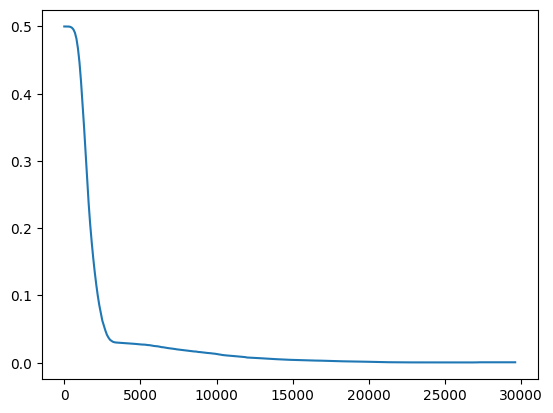

In [9]:
plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
# plt.xscale('log')

# Use Dask to distribute among slurm nodes

In [23]:
from dask_jobqueue import SLURMCluster

In [28]:
import os

In [ ]:
def calculate_rich_club_coefficients(target_synaptome, seed):
    model_dp = WeightPermutedRandomModel(target_synaptome)
    dp_adj = model_dp.generate(seed=seed)

    rca_dp = RichClubAnalysis(dp_adj)
    k_dict_parallel_dp = rca_dp.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
    return k_dict_parallel_dp.values()

In [40]:
n_trials = 5

# setup SLURM cluster
random_type = 'WP'
cluster = SLURMCluster(queue='prod', 
                       cores=4,
                       name=f'rich_club_{random_type}',
                       log_directory = f'{os.getcwd()}/slurm_logs/',
                       memory="32GB", 
                       walltime='01:00:00',
                       account='proj112',
#                       job_script="/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/toolbox/graph_analysis/notebooks/dask_worker.sbatch",
                      )

/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33475 instead
  warnings.warn(


In [37]:
client = Client(cluster)

# adjust the scale to match the number of trials (this might vary depending on your setup)
cluster.scale(n_trials)  

In [38]:
futures = client.map(calculate_rich_club_coefficients, [target_synaptome]*n_trials, range(n_trials))

In [39]:
results = client.gather(futures)

KilledWorker: Attempted to run task calculate_rich_club_coefficients-0bf74057757f42f3257b16e29752730b on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://10.80.155.244:41403. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [41]:
results

NameError: name 'results' is not defined

In [42]:
client.close()
cluster.close()

# Analyze results

In [3]:
output_dir = '../examples/output/'

In [4]:
import glob
import pickle

In [7]:
paths = glob.glob(f'{output_dir}/20_random*')
filtered_paths = [path for path in paths if 10 < int(path.split('_')[-1].split('.')[0]) < 20]


In [8]:
filtered_paths

['../examples/output/20_random_rc_coeffs_13.pkl',
 '../examples/output/20_random_rc_coeffs_12.pkl',
 '../examples/output/20_random_rc_coeffs_15.pkl',
 '../examples/output/20_random_rc_coeffs_11.pkl',
 '../examples/output/20_random_rc_coeffs_14.pkl']

In [22]:
random_rc_coeffs = []
for i in filtered_paths:
    with open(i, 'rb') as f:
        data = pickle.load(f)
        random_rc_coeffs.extend(data)
random_rc_coeffs = pd.DataFrame(random_rc_coeffs)

In [37]:
earliest_nan_column_index = random_rc_coeffs.isnull().idxmax(axis=1)
earliest_nan_column_index.min()

21601.0

In [39]:
random_rc_coeffs = random_rc_coeffs.loc[:,:earliest_nan_column_index.min()]

In [43]:
output_dir = '../output/rich_club/'

In [44]:
random_rc_coeffs.to_csv(f'{output_dir}/random_rc_coeffs.csv')

<Axes: >

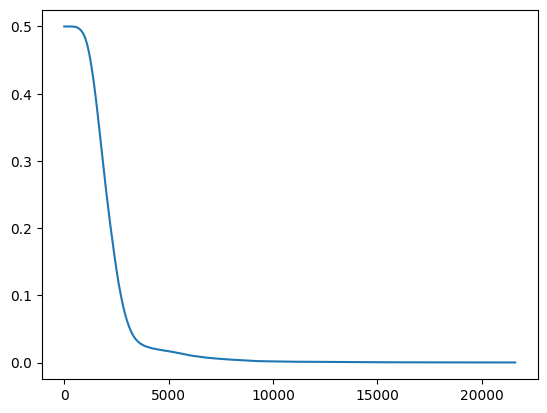

In [41]:
random_rc_coeffs.mean(axis=0).plot()

In [20]:
# Calculate average over trials
random_rc_coeffs_avg = np.mean(random_rc_coeffs, axis=0)

# Calculate normalized rich club coefficients
norm_rc = rc_coeffs_model[:random_rc_coeffs_avg.shape[0]] / random_rc_coeffs_avg

# Statistical test
_, p_value = ttest_ind(norm_rc_trials, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (6, 20) + inhomogeneous part.

In [ ]:
# Plot the results
f, ax = plt.subplots(figsize=(10,8))
plt.plot(k_dict_parallel_dp.keys(), norm_rc_avg)

ax.fill_between(k_dict_parallel_dp.keys(), norm_rc_avg, 1, where=(np.array(norm_rc_avg) >= 1), color='lightblue', alpha=0.4)
ax.fill_between(k_dict_parallel_dp.keys(), norm_rc_avg, 1, where=(np.array(norm_rc_avg) < 1), color='lightyellow', alpha=0.4)

ax.axhline(y=1, color='k', linestyle='--', label='y=1')

plt.title('Average Normalized Rich Club Coefficients for slice10 synaptome (total-weights)')
plt.xlabel('k (synapses)')
plt.ylabel('Norm. Rich Club Coefficient')
plt.legend(['norm_RC_coeff (CA1/weight_permuted)'])
plt.savefig(f"../output/rich_club_directed_totdegree_weighted.png", dpi=dpi, bbox_inches='tight')